#Calibration of a detector parameters using a single crystal
###(*e.g. ruby standard*)

This script is made to run using the yml file and output of `fit-grains`. The script uses soon-to-be-deprecated detector parameters exported by the GUI and generates a new and complete instrument calibration file.

In practise, you will probably run this script through several times, using the previous result to converge on a solution. The script will **overwrite** the detector parameter files to allow this (both old and new, but the old file spec lacks the chi-tilt optimization.)

##User input here!

In [41]:
# hexrd yaml config file
cfg_filename = 'example_config.yml'

# select which orientaion to use (in case of more than one...)
grain_id = 0
override_grain_params = False

# for saturation
int_cutoff = 1.4e4

Ok, that was easy, from here on you shouldn't need to modify anything.

In [42]:
import sys, os
import numpy as np

from scipy.stats import chisquare

from IPython.html import widgets
from IPython.display import display

import yaml
from scipy.linalg.matfuncs import logm
import scipy.optimize as opt

from hexrd import matrixutil as mutil

# * imports are not a good idea, comment for now
from hexrd.coreutil import initialize_experiment, tVec_d_from_old_detector_params, make_old_detector_parfile
from hexrd import config

from hexrd.xrd import distortion as dFuncs
from hexrd.xrd import fitting
from hexrd.xrd import material
from hexrd.xrd import transforms as xf
from hexrd.xrd.transforms import bVec_ref, eta_ref, vInv_ref
from hexrd.xrd import transforms_CAPI as xfcapi

# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline
from matplotlib import pyplot as plt

# Choose a bunch of new matplotlib parameter values
newparams = {'savefig.dpi': 150, 'axes.labelsize': 12, 
             'xtick.labelsize': 6, 'ytick.labelsize': 6}

# Update the global rcParams dictionary with the new parameter choices
plt.rcParams.update(newparams)


###Define some local parameters.

Note that the variable "det_origin" is a 2-tuple containing the detector panel centroid coordinates in mm as measured from the lower-left corner of the panel (this was the origin in the old hexrd scheme).  For the GE detector or Perkin-Elmer, this would be (204.8, 204.8).  *This is a legacy feature that is necessitated by the use of older hexrd (v0.1) detector parameters files and will likely become obselete at some point.*

In [43]:
det_origin = (204.8, 204.8) # for GE

d2r = np.radians(1)
r2d = np.degrees(1)

###Setup up detector parameter widget

In [44]:
# Default detector refinement flags
#   - kludge to not overwrite pFlag_DFLT if already defined/modified
try:
    test = pFlag_DFLT
except NameError:
    pFlag_DFLT = np.array([1, 1, 1, 
                           1, 1, 1, 
                           1, 
                           0, 0, 0, 
                           1, 1, 1, 
                           1, 0, 1], dtype=bool)

# detector parameter scalings
pScl  = np.array([d2r, d2r, d2r, 
                  10., 10., 1000.,
                  d2r,
                  1., 1., 1.,
                  1., 1., 1.,
                  1., 1., 1.])

tilt_x_chk = widgets.Checkbox(description="X tilt", value=bool(pFlag_DFLT[0]))
tilt_y_chk = widgets.Checkbox(description="Y tilt", value=bool(pFlag_DFLT[1]))
tilt_z_chk = widgets.Checkbox(description="Z tilt", value=bool(pFlag_DFLT[2]))
tvd_x_chk = widgets.Checkbox(description="tVec_d[0]", value=bool(pFlag_DFLT[3]))
tvd_y_chk = widgets.Checkbox(description="tVec_d[1]", value=bool(pFlag_DFLT[4]))
tvd_z_chk = widgets.Checkbox(description="tVec_d[2]", value=bool(pFlag_DFLT[5]))
chi_chk = widgets.Checkbox(description="chi", value=bool(pFlag_DFLT[6]))
tvs_x_chk = widgets.Checkbox(description="tVec_s[0]", value=bool(pFlag_DFLT[7]))
tvs_y_chk = widgets.Checkbox(description="tVec_s[1]", value=bool(pFlag_DFLT[8]))
tvs_z_chk = widgets.Checkbox(description="tVec_s[2]", value=bool(pFlag_DFLT[9]))
expm_x_chk = widgets.Checkbox(description="expMap_c[0]", value=bool(pFlag_DFLT[10]))
expm_y_chk = widgets.Checkbox(description="expMap_c[1]", value=bool(pFlag_DFLT[11]))
expm_z_chk = widgets.Checkbox(description="expMap_c[2]", value=bool(pFlag_DFLT[12]))
tvc_x_chk = widgets.Checkbox(description="tVec_c[0]", value=bool(pFlag_DFLT[13]))
tvc_y_chk = widgets.Checkbox(description="tVec_c[1]", value=bool(pFlag_DFLT[14]))
tvc_z_chk = widgets.Checkbox(description="tVec_c[2]", value=bool(pFlag_DFLT[15]))

detector_params_container = widgets.ContainerWidget()
detector_params_container.children = [tilt_x_chk, tilt_y_chk, tilt_z_chk, tvd_x_chk, tvd_y_chk, tvd_z_chk]

oscill_params_container = widgets.ContainerWidget()
oscill_params_container.children = [chi_chk, tvs_x_chk, tvs_y_chk, tvs_z_chk]

crystal_params_container = widgets.ContainerWidget()
crystal_params_container.children = [expm_x_chk, expm_y_chk, expm_z_chk, tvc_x_chk, tvc_y_chk, tvc_z_chk]

###Setup distortion parameters widget

In [45]:
# Select distortion function from distortion module
#   - currently all we have is the GE distrotion function, so this is hard-coded.  
#     Will transition to some kind of parameter file once it is decided what the 
#     API should look like.
dFunc = dFuncs.GE_41RT
dParams = [0., 0., 0., 2., 2., 2]
dScl  = np.array([1e4, 1e4, 1e4, 1., 1., 1.])
# Default distortion refinement flags
#   - kludge to not overwrite pFlag_DFLT if already defined/modified
try:
    test = dFlag_DFLT
except NameError:
    dFlag_DFLT = np.array([1, 1, 1, 0, 0, 0], dtype=bool)

dparm_0_chk = widgets.Checkbox(description=r"$p_0$", value=bool(dFlag_DFLT[0]))
dparm_1_chk = widgets.Checkbox(description=r"$p_1$", value=bool(dFlag_DFLT[1]))
dparm_2_chk = widgets.Checkbox(description=r"$p_2$", value=bool(dFlag_DFLT[2]))
dparm_3_chk = widgets.Checkbox(description=r"$n_0$", value=bool(dFlag_DFLT[3]))
dparm_4_chk = widgets.Checkbox(description=r"$n_1$", value=bool(dFlag_DFLT[4]))
dparm_5_chk = widgets.Checkbox(description=r"$n_2$", value=bool(dFlag_DFLT[5]))

distortion_params_container = widgets.ContainerWidget()
distortion_params_container.children = [dparm_0_chk, dparm_1_chk, dparm_2_chk, 
                                        dparm_3_chk, dparm_4_chk, dparm_5_chk]

#Refinement Flags
##Here we have to define all of the refinement flags and scalings for the instrument calibration parameters
###Definitions:
+ the first **6** parameters describe the panel
        tiltAngles[0]   (tilt about lab X)
        tiltAngles[1]   (tilt about lab Y)
        tiltAngles[2]   (tilt about lab Z -- also panel normal)
        tVec_d[0]       (x-translation; 0 means centered on beam horizontally)
        tVec_d[1]       (y-translation; 0 means centered on beam vertically)
        tVec_d[2]       (z-translation; working distance, where values < 0 are downstream)
+ the next **4** describe the rotation (sample) frame
        chi             (canting angle of rotation axis about lab X)
        tVec_s[0]       (rotation axis x-translation; typically 0)
        tVec_s[1]       (rotation axis y-translation; typically 0)
        tVec_s[2]       (rotation axis z-translation; typically 0)
+ the last **6** parameters describe the crystal.  Note the strain (if any) is *fixed*
        expMap_c[0]     (crystal orientation phi*n[0])
        expMap_c[1]     (crystal orientation phi*n[1])
        expMap_c[2]     (crystal orientation phi*n[2])
        tVec_c[0]       (crystal centroid x-translation)
        tVec_c[1]       (crystal centroid y-translation)
        tVec_c[2]       (crystal centroid z-translation)

In [46]:
refineFlag_panel = widgets.Accordion()
refineFlag_panel.children = [detector_params_container, 
                            oscill_params_container, 
                            crystal_params_container, 
                            distortion_params_container]
refineFlag_panel.set_title(0, "Detector Panel")
refineFlag_panel.set_title(1, "Oscillation Stage")
refineFlag_panel.set_title(2, "Calibration Crystal")
refineFlag_panel.set_title(3, "Distortion Parameters")

###Set refinement flags from widget choices

In [47]:
refineFlag_panel

In [48]:
dFlag = np.array([dparm_0_chk.value, dparm_1_chk.value, dparm_2_chk.value, 
                  dparm_3_chk.value, dparm_4_chk.value, dparm_5_chk.value], dtype=bool)
pFlag = np.array([tilt_x_chk.value, tilt_y_chk.value, tilt_z_chk.value, 
                  tvd_x_chk.value, tvd_y_chk.value, tvd_z_chk.value, 
                  chi_chk.value, 
                  tvs_x_chk.value, tvs_y_chk.value, tvs_z_chk.value, 
                  expm_x_chk.value, expm_y_chk.value, expm_z_chk.value, 
                  tvc_x_chk.value, tvc_y_chk.value, tvc_z_chk.value], dtype=bool)

# catch bad logic
if pFlag[4] and pFlag[-2]:
    raise RuntimeError, "You've specified refinement of both the Y translation " \
    "of the detector and crystal, which are correlated"
dFlag_DFLT = dFlag
pFlag_DFLT = pFlag
refineFlag = np.hstack([pFlag, dFlag])

##Crystal fit parameters

In [49]:
# set parameters for post-fit crystal parameter check...
#   - this mainly makes sense in terms of a calibration standard, since we cant
#     simultaneously fit strain and detector parameters (e.g. distance)
try:
    test = gFlag_DFLT
except NameError:
    gFlag_DFLT = np.array([1, 1, 1,
                           1, 1, 1, 
                           0, 0, 0, 0, 0, 0], dtype=bool)
# grain parameter scalings
gScl  = np.array([1., 1., 1.,
                  1., 1., 1.,
                  1., 1., 1., 0.01, 0.01, 0.01])

# make widgets for flagging refinement
g_params_00_chk = widgets.Checkbox(description="expMap_c[0]", value=bool(gFlag_DFLT[0]))
g_params_01_chk = widgets.Checkbox(description="expMap_c[1]", value=bool(gFlag_DFLT[1]))
g_params_02_chk = widgets.Checkbox(description="expMap_c[2]", value=bool(gFlag_DFLT[2]))
g_params_03_chk = widgets.Checkbox(description="tVec_c[0]", value=bool(gFlag_DFLT[3]))
g_params_04_chk = widgets.Checkbox(description="tVec_c[1]", value=bool(gFlag_DFLT[4]))
g_params_05_chk = widgets.Checkbox(description="tVec_c[2]", value=bool(gFlag_DFLT[5]))
g_params_06_chk = widgets.Checkbox(description="vInv_s[0]", value=bool(gFlag_DFLT[6]))
g_params_07_chk = widgets.Checkbox(description="vInv_s[1]", value=bool(gFlag_DFLT[7]))
g_params_08_chk = widgets.Checkbox(description="vInv_s[2]", value=bool(gFlag_DFLT[8]))
g_params_09_chk = widgets.Checkbox(description="vInv_s[3]", value=bool(gFlag_DFLT[9]))
g_params_10_chk = widgets.Checkbox(description="vInv_s[4]", value=bool(gFlag_DFLT[10]))
g_params_11_chk = widgets.Checkbox(description="vInv_s[5]", value=bool(gFlag_DFLT[11]))

orientation_container = widgets.ContainerWidget()
orientation_container.children = [g_params_00_chk, g_params_01_chk, g_params_02_chk]
position_container = widgets.ContainerWidget()
position_container.children = [g_params_03_chk, g_params_04_chk, g_params_05_chk]
stretch_container = widgets.ContainerWidget()
stretch_container.children = [g_params_06_chk, g_params_07_chk, g_params_08_chk, 
                              g_params_09_chk, g_params_10_chk, g_params_11_chk]

gFlag_panel = widgets.Accordion()
gFlag_panel.children = [orientation_container, position_container, stretch_container]
gFlag_panel.set_title(0, "Orientation")
gFlag_panel.set_title(1, "Position")
gFlag_panel.set_title(2, "Stretch")

##For verifying the crystal parameters (i.e. including strain fit)
###Definitions:
+ the first **6** parameters describe the crystal as above
        expMap_c[0]     (crystal orientation phi*n[0])
        expMap_c[1]     (crystal orientation phi*n[1])
        expMap_c[2]     (crystal orientation phi*n[2])
        tVec_c[0]       (crystal centroid x-translation)
        tVec_c[1]       (crystal centroid y-translation)
        tVec_c[2]       (crystal centroid z-translation)
+ the last **6** parameters describe inverse stretch tensor components (sample frame)
        vInv_s[0]   (inv(V)[0, 0])
        vInv_s[1]   (inv(V)[1, 1])
        vInv_s[2]   (inv(V)[2, 2])
        vInv_s[3]   (inv(V)[1, 2] * sqrt(2))
        vInv_s[4]   (inv(V)[0, 2] * sqrt(2))
        vInv_s[5]   (inv(V)[0, 1] * sqrt(2))

In [50]:
gFlag_panel

In [51]:
# assign gFlag from checkbox states
gFlag = np.array([g_params_00_chk.value, g_params_01_chk.value, g_params_02_chk.value, 
                  g_params_03_chk.value, g_params_04_chk.value, g_params_05_chk.value, 
                  g_params_06_chk.value, g_params_07_chk.value, g_params_08_chk.value, 
                  g_params_09_chk.value, g_params_10_chk.value, g_params_11_chk.value], dtype=bool)
gFlag_DFLT = gFlag

###Read configuration file

In [52]:
# read config
cfg = config.open(cfg_filename)[0]

# output for eta-ome maps as pickles
working_dir = cfg.working_dir
analysis_name = cfg.analysis_name
analysis_dir = cfg.analysis_dir

old_parfilename = cfg.instrument.detector.parameters_old
# This should use the yaml detector spec, but it appears to include crystal parameters as well:
new_parfilename = cfg.instrument.parameters
quats_filename = os.path.join(working_dir, 'accepted_orientations.dat')
spots_filename = os.path.join(analysis_dir, 'spots_%05d.out' % grain_id)

pd, reader, detector = initialize_experiment(cfg)

bMat = np.ascontiguousarray(pd.latVecOps['B']) # hexrd convention; necessary to re-cast (?)
wlen = pd.wavelength * 1.0# Angstroms


# omega period 
omePeriod = d2r*np.array(cfg.find_orientations.omega.period, dtype=float)

###Initialize fit parameters

In [53]:
# load old hexrd detector file
old_par = np.vstack([detector.getParams(allParams=True), 
                     np.zeros_like(detector.getParams(allParams=True))]).T

# THIS IS HARD-CODED FOR GE-TYPE DISTORTION! 
# MUST CHANGE EVENTUALLY...
dParams = old_par[-6:, 0]
    
if override_grain_params:
    grain_params = np.loadtxt(os.path.join(analysis_dir, 'grains.out'), ndmin=2)[grain_id, :]
    expMap_c = grain_params[3:6]
    tVec_c = grain_params[6:9]
    vInv_s = grain_params[9:15]
else:
    try:
        new_par = yaml.load(open(new_parfilename, 'r'))
        
        if new_par['calibration_crystal'].get('grain_id', -1) != grain_id:
            # the cached grain id is not the current grain id
            # start over from default values
            raise RuntimeError
        
        tiltAngles = new_par['detector']['transform']['tilt_angles']
        tVec_d = np.array(new_par['detector']['transform']['t_vec_d'])
        chi = new_par['oscillation_stage']['chi']
        tVec_s = np.array(new_par['oscillation_stage']['t_vec_s'])
        expMap_c = np.array(new_par['calibration_crystal']['orientation'])
        tVec_c = np.array(new_par['calibration_crystal']['position'])
        vInv_s = np.array(new_par['calibration_crystal']['inv_stretch'])
    except (IOError, KeyError, RuntimeError):
        all_quats = xf.unitVector(np.loadtxt(quats_filename, ndmin=2).T)
        quat = all_quats[:, grain_id].reshape(4, 1)
        phi = 2*np.arccos(quat[0])
        n = xf.unitVector(quat[1:].reshape(3, 1))
        
        tiltAngles = old_par[3:6, 0]
        tVec_d = tVec_d_from_old_detector_params(old_par, det_origin)
        chi = 0.
        tVec_s = np.zeros((3, 1))
        expMap_c = phi*n
        tVec_c = np.zeros((3, 1))
        vInv_s = vInv_ref

In [54]:
# load grain
gtable = np.loadtxt(spots_filename) # load pull_spots output table
valid_reflections = gtable[:, 0] >= 0
not_saturated = gtable[:, 6] < int_cutoff
print "INFO: %d of %d reflections are valid" %(sum(valid_reflections), len(gtable))
print "INFO: %d of %d valid reflections be are below saturation threshold of %d" \
    %(sum(not_saturated), sum(valid_reflections), int_cutoff)

idx = np.logical_and(valid_reflections, not_saturated) # select valid reflections
idx_0 = idx # will need this later
hkls = gtable[idx, 2:5].T # must be column vectors
xyo_det = gtable[idx, -3:] # these are the cartesian centroids + ome
xyo_det[:, 2] = xf.mapAngle(xyo_det[:, 2], omePeriod)

nrefl = sum(idx)

p_initial = fitting.geomParamsToInput(tiltAngles, chi, expMap_c, tVec_d, tVec_s, tVec_c, dParams)
g_initial = np.hstack([expMap_c.flatten(), tVec_c.flatten(), vInv_s.flatten()])

#List of parameter names for convenience and printing output
pnames = [ 'tiltAngles[0]', 
           'tiltAngles[1]', 
           'tiltAngles[2]', 
           '    tVec_d[0]',   
           '    tVec_d[1]',   
           '    tVec_d[2]',   
           '          chi',   
           '    tVec_s[0]',   
           '    tVec_s[1]',   
           '    tVec_s[2]',   
           '  expMap_c[0]',   
           '  expMap_c[1]',   
           '  expMap_c[2]',   
           '    tVec_c[0]',   
           '    tVec_c[1]',   
           '    tVec_c[2]']
for i in range(len(dParams)):
    pnames.append('   dParams[%d]' %i)

print "Setup to refine:\n"
for i in np.where(refineFlag)[0]:
    print "\t%s = %1.7e" %(pnames[i], p_initial[i])
print "\nCalibartion Crystal's Hencky Strain Tensor (sample frame):\n"
print logm(np.linalg.inv(mutil.vecMVToSymm(vInv_s)))

pScl = np.ones(16)
dScl = np.ones_like(dParams)

# convergence tolerances for the least-squares fit
xtol = 1e-7
ftol = 1e-7

INFO: 461 of 499 reflections are valid
INFO: 414 of 461 valid reflections be are below saturation threshold of 14000
Setup to refine:

	tiltAngles[0] = 6.5340402e-04
	tiltAngles[1] = -3.0900678e-03
	tiltAngles[2] = -2.3171279e-03
	    tVec_d[0] = -1.4471097e+00
	    tVec_d[1] = -3.2350025e+00
	    tVec_d[2] = -1.0506006e+03
	          chi = -8.7379763e-04
	  expMap_c[0] = 6.6911552e-01
	  expMap_c[1] = -9.8658099e-01
	  expMap_c[2] = 7.3674475e-01
	   dParams[0] = -4.0951060e-05
	   dParams[1] = -8.0272460e-05
	   dParams[2] = -5.6461008e-04

Calibartion Crystal's Hencky Strain Tensor (sample frame):

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


###Check initial guess graphically

Initial goodness of fit:	1.4995e-06


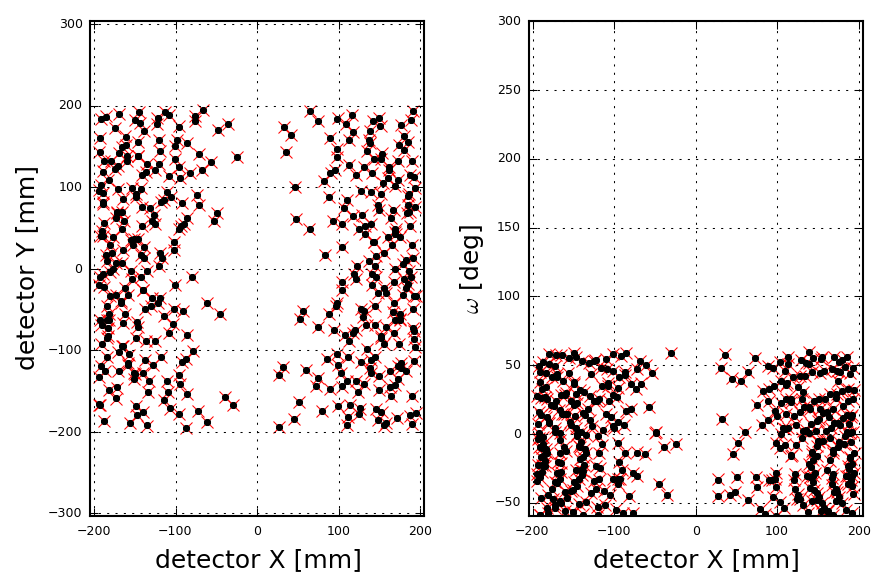

In [55]:
# check out initial residual
xyo_i = fitting.objFuncSX(
    p_initial[refineFlag], p_initial, pFlag, dFunc, dFlag,
    xyo_det, hkls, bMat, vInv_s, wlen,
    bVec_ref, eta_ref, omePeriod, simOnly=True
    )

resd_i = fitting.objFuncSX(
    p_initial[refineFlag], p_initial, pFlag, dFunc, dFlag,
    xyo_det, hkls, bMat, vInv_s, wlen,
    bVec_ref, eta_ref, omePeriod, simOnly=False
    )

nu_fac = 1/(nrefl - sum(refineFlag) - 1.)
chi2_i = nu_fac*sum(resd_i**2/xyo_i.flatten())
print "Initial goodness of fit:\t%1.4e" %chi2_i

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(xyo_det[:, 0], xyo_det[:, 1], 'rx')
ax1.plot(xyo_i[:, 0], xyo_i[:, 1], 'k.')
ax1.grid(True)
ax1.axis('equal')
ax1.set_xlim((-204.8, 204.8))
ax1.set_ylim((-204.8, 204.8))
ax1.set_xlabel('detector X [mm]')
ax1.set_ylabel('detector Y [mm]')

ax2 = fig.add_subplot(122)
ax2.plot(xyo_det[:, 0], r2d*xyo_det[:, 2], 'rx')
ax2.plot(xyo_i[:, 0], r2d*xyo_i[:, 2], 'k.')
ax2.grid(True)
ax2.set_xlim((-204.8, 204.8))
ax2.set_ylim(r2d*omePeriod[0], r2d*omePeriod[1])
ax2.set_xlabel('detector X [mm]')
ax2.set_ylabel(r'$\omega$ [deg]')

plt.tight_layout()
plt.show()



#*SKIP TO HERE AND RUN ALL ABOVE*
###If things look pretty good, then we are ready to do the optimization

Initial chi2:	1.50e-06
Final chi2:	9.29e-07
Refined parameters:
	Name		Initial		Final
	----		-------		-----
	tiltAngles[0]	6.5340402e-04	6.2977243e-04
	tiltAngles[1]	-3.0900678e-03	-3.0874055e-03
	tiltAngles[2]	-2.3171279e-03	-2.3196726e-03
	    tVec_d[0]	-1.4471097e+00	-1.4471482e+00
	    tVec_d[1]	-3.2350025e+00	-3.2341780e+00
	    tVec_d[2]	-1.0506006e+03	-1.0505949e+03
	          chi	-8.7379763e-04	-8.9986272e-04
	  expMap_c[0]	6.6911552e-01	6.6910381e-01
	  expMap_c[1]	-9.8658099e-01	-9.8662120e-01
	  expMap_c[2]	7.3674475e-01	7.3676027e-01
	   dParams[0]	-4.0951060e-05	-3.8673951e-05
	   dParams[1]	-8.0272460e-05	-8.2068229e-05
	   dParams[2]	-5.6461008e-04	-5.7315865e-04




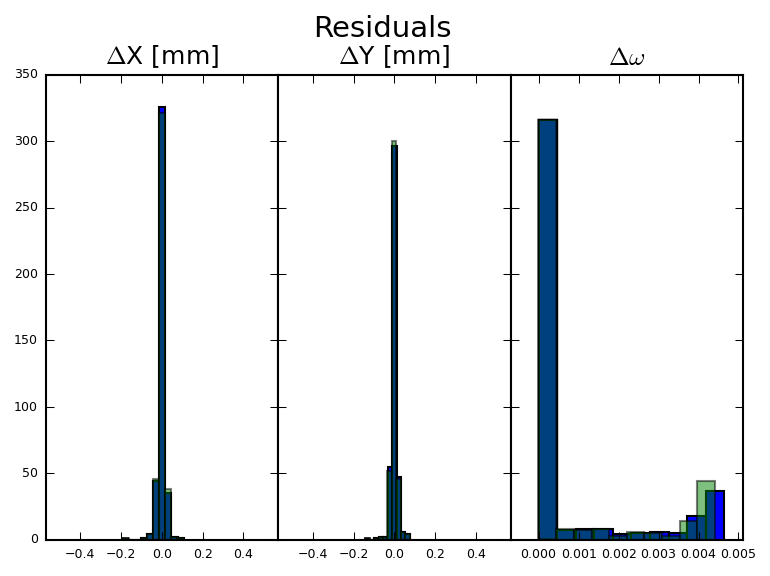

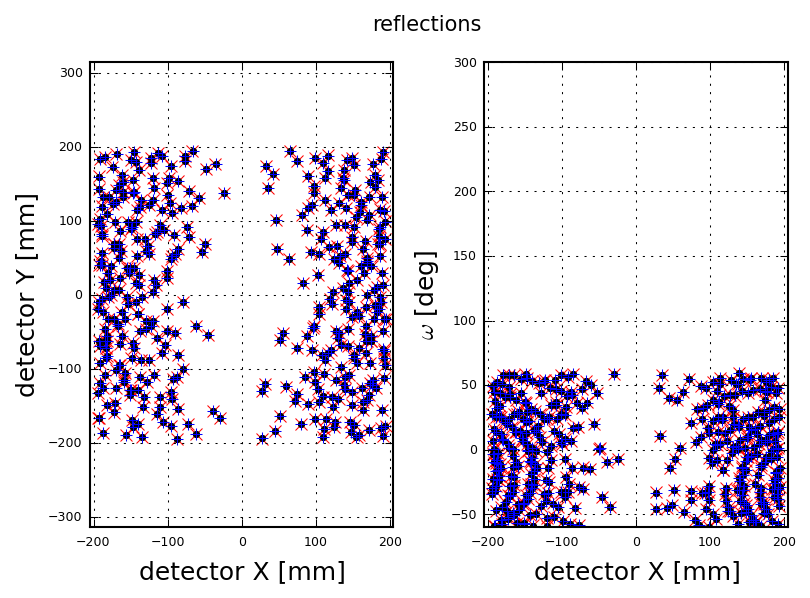

In [56]:
# fitting
p_refined = fitting.calibrateDetectorFromSX(
    xyo_det, hkls, bMat, wlen, tiltAngles, chi, expMap_c, tVec_d,
    tVec_s, tVec_c, vInv=vInv_s,  beamVec=bVec_ref, etaVec=eta_ref,
    distortion=(dFunc, dParams, dFlag, dScl), pFlag=pFlag,
    pScl=pScl, factor=1.0, xtol=xtol, ftol=xtol, omePeriod=omePeriod
    )

results = fitting.inputToGeomParams(p_refined)

resd_f = fitting.objFuncSX(
    p_refined[refineFlag], p_refined, pFlag, dFunc, dFlag,
    xyo_det, hkls, bMat, vInv_s, wlen,
    bVec_ref, eta_ref, omePeriod, simOnly=False
    )
xyo_f = fitting.objFuncSX(
    p_refined[refineFlag], p_refined, pFlag, dFunc, dFlag,
    xyo_det, hkls, bMat, vInv_s, wlen,
    bVec_ref, eta_ref, omePeriod, simOnly=True
    )

# new style method 2; use an axes array
fig1, axs1 = plt.subplots(1, 3, sharex=False, sharey=True)
fig1.subplots_adjust(wspace=0)
fig1.suptitle("Residuals", fontsize=14, y=1.0)
titles = [r'$\Delta$X [mm]', r'$\Delta$Y [mm]', r'$\Delta\omega$']
for i in range(3):
    axs1[i].hist(resd_i.reshape(sum(idx), 3)[:, i], color='b')
    axs1[i].hist(resd_f.reshape(sum(idx), 3)[:, i], color='g', alpha=0.5)
    axs1[i].set_title(titles[i], fontsize=12)
    if i > 1:
        axs1[i].set_xlim(-0.0007, np.max(resd_f.reshape(sum(idx), 3)[:, i])+0.0007)
        axs1[i].set_xlim(-0.0007, np.max(resd_f.reshape(sum(idx), 3)[:, i])+0.0007)
    else:
        axs1[i].set_xlim(-0.57, 0.57)
        axs1[i].set_xlim(-0.57, 0.57)

chi2_f = nu_fac*sum(resd_f**2/xyo_f.flatten())
print "Initial chi2:\t%1.2e\nFinal chi2:\t%1.2e\nRefined parameters:" \
    %(chi2_i, chi2_f)
print "\tName\t\tInitial\t\tFinal"
print "\t----\t\t-------\t\t-----"
for i in np.where(refineFlag)[0]:
    print "\t%s\t%1.7e\t%1.7e" %(pnames[i], p_initial[i], p_refined[i])
print "\n"

# keep
pref0 = p_refined

fig2, axs2 = plt.subplots(1, 2, sharex=True, sharey=False)
fig2.subplots_adjust(wspace=0.3)
fig2.suptitle("reflections")

axs2[0].plot(xyo_det[:, 0], xyo_det[:, 1], 'rx')
axs2[0].plot(xyo_i[:, 0], xyo_i[:, 1], 'k.')
axs2[0].plot(xyo_f[:, 0], xyo_f[:, 1], 'b+')
axs2[0].grid(True)
axs2[0].axis('equal')
axs2[0].set_xlim((-204.8, 204.8))
axs2[0].set_ylim((-204.8, 204.8))
axs2[0].set_xlabel('detector X [mm]')
axs2[0].set_ylabel('detector Y [mm]')

axs2[1].plot(xyo_det[:, 0], r2d*xyo_det[:, 2], 'rx')
axs2[1].plot(xyo_i[:, 0], r2d*xyo_i[:, 2], 'k.')
axs2[1].plot(xyo_f[:, 0], r2d*xyo_f[:, 2], 'b+')
axs2[1].grid(True)
axs2[1].set_xlim((-204.8, 204.8))
axs2[1].set_ylim(r2d*omePeriod[0], r2d*omePeriod[1])
axs2[1].set_xlabel('detector X [mm]')
axs2[1].set_ylabel(r'$\omega$ [deg]')

##At this point we can re-refine after removing outliers
First, define tolerances in terms of pixels (x, y) and frames (omega)

In [57]:
n_pixels_tol = 1.0
n_frames_tol = 1.0

# define difference vectors for spot fits
x_diff = abs(xyo_det[:, 0] - xyo_f[:, 0])
y_diff = abs(xyo_det[:, 1] - xyo_f[:, 1])
ome_diff = r2d*xf.angularDifference(xyo_det[:, 2], xyo_f[:, 2])

# filter out reflections with centroids more than 
# a pixel and delta omega away from predicted value
idx_1 = np.logical_and(
    x_diff <= n_pixels_tol*cfg.instrument.detector.pixels.size[1],
    np.logical_and(y_diff <= n_pixels_tol*cfg.instrument.detector.pixels.size[0], 
                   ome_diff <= n_frames_tol*cfg.image_series.omega.step))

print "INFO: Will keep %d of %d input reflections for re-fit" %(sum(idx_1), sum(idx))
idx_new = np.zeros_like(idx, dtype=bool)
idx_new[np.where(idx_0 == 1)[0][idx_1]] = True
idx_0 = idx_new

INFO: Will keep 394 of 414 input reflections for re-fit


First fit chi2:	1.50e-06
Re-fit chi2:	-1.44e-06
Refined parameters:
	Name		First		Final
	----		-------		-----
	tiltAngles[0]	6.2977243e-04	6.5343174e-04
	tiltAngles[1]	-3.0874055e-03	-3.0900720e-03
	tiltAngles[2]	-2.3196726e-03	-2.3171297e-03
	    tVec_d[0]	-1.4471482e+00	-1.4471098e+00
	    tVec_d[1]	-3.2341780e+00	-3.2350047e+00
	    tVec_d[2]	-1.0505949e+03	-1.0506006e+03
	          chi	-8.9986272e-04	-8.7367723e-04
	  expMap_c[0]	6.6910381e-01	6.6911554e-01
	  expMap_c[1]	-9.8662120e-01	-9.8658094e-01
	  expMap_c[2]	7.3676027e-01	7.3674472e-01
	   dParams[0]	-3.8673951e-05	-4.0944209e-05
	   dParams[1]	-8.2068229e-05	-8.0275495e-05
	   dParams[2]	-5.7315865e-04	-5.6461450e-04




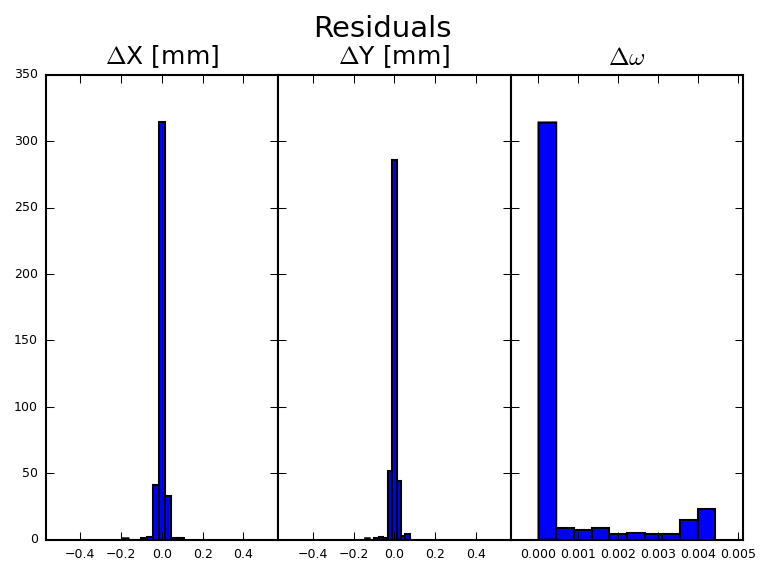

In [58]:
# trim grain table
hkls = gtable[idx_new, 2:5].T
xyo_det = gtable[idx_new, -3:]
# REFIT!
p_refined = fitting.calibrateDetectorFromSX(
    xyo_det, hkls, bMat, wlen, results['tiltAngles'], results['chi'],
    results['expMap_c'], results['tVec_d'], results['tVec_s'],
    results['tVec_c'], vInv=vInv_s,  beamVec=bVec_ref, etaVec=eta_ref,
    distortion=(dFunc, results['dParams'], dFlag, dScl), pFlag=pFlag,
    pScl=pScl, factor=1.0, xtol=xtol, ftol=xtol, omePeriod=omePeriod
    )

results = fitting.inputToGeomParams(p_refined)

# dump old detector parfile
make_old_detector_parfile(results, det_origin=det_origin, filename=old_parfilename)

resd_f = fitting.objFuncSX(
    p_refined[refineFlag], p_refined, pFlag, dFunc, dFlag,
    xyo_det, hkls, bMat, vInv_s, wlen,
    bVec_ref, eta_ref, omePeriod, simOnly=False
    )
xyo_f = fitting.objFuncSX(
    p_refined[refineFlag], p_refined, pFlag, dFunc, dFlag,
    xyo_det, hkls, bMat, vInv_s, wlen,
    bVec_ref, eta_ref, omePeriod, simOnly=True
    )

nrefl = len(resd_f) / 3 # updated
nu_fac = 1/(nrefl - sum(refineFlag) - 1.)
chi2_f = nu_fac*sum(resd_f**2/xyo_f.flatten())
print "First fit chi2:\t%1.2e\nRe-fit chi2:\t%1.2e\nRefined parameters:" \
    %(chi2_i, chi2_f)
print "\tName\t\tFirst\t\tFinal"
print "\t----\t\t-------\t\t-----"
for i in np.where(refineFlag)[0]:
    print "\t%s\t%1.7e\t%1.7e" %(pnames[i], pref0[i], p_refined[i])
print "\n"

# new style method 2; use an axes array
fig3, axs3 = plt.subplots(1, 3, sharex=False, sharey=True)
fig3.subplots_adjust(wspace=0)
fig3.suptitle("Residuals", fontsize=14, y=1.0)
titles = [r'$\Delta$X [mm]', r'$\Delta$Y [mm]', r'$\Delta\omega$']
for i in range(3):
    axs3[i].hist(resd_f.reshape(sum(idx_new), 3)[:, i], color='b')
    axs3[i].set_title(titles[i], fontsize=12)
    if i > 1:
        axs3[i].set_xlim(-0.0007, np.max(resd_f.reshape(sum(idx_new), 3)[:, i])+0.0007)
        axs3[i].set_xlim(-0.0007, np.max(resd_f.reshape(sum(idx_new), 3)[:, i])+0.0007)
    else:
        axs3[i].set_xlim(-0.57, 0.57)
        axs3[i].set_xlim(-0.57, 0.57)
        

##Now check

Review of chi2 values:
	Initial		Detector only	Strain fit

	-------		-------------	----------
	1.4995e-06	-1.4427e-06	-1.4058e-06

Calibrant Hencky Strain Tensor (sample frame):

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

Centroidal coordinates [microns]:
	X		Y		Z
	0.000e+00	0.000e+00	0.000e+00


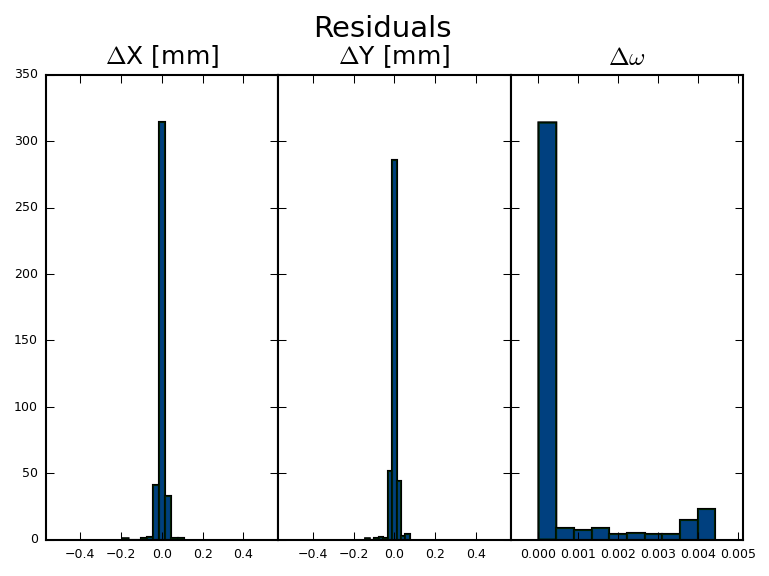

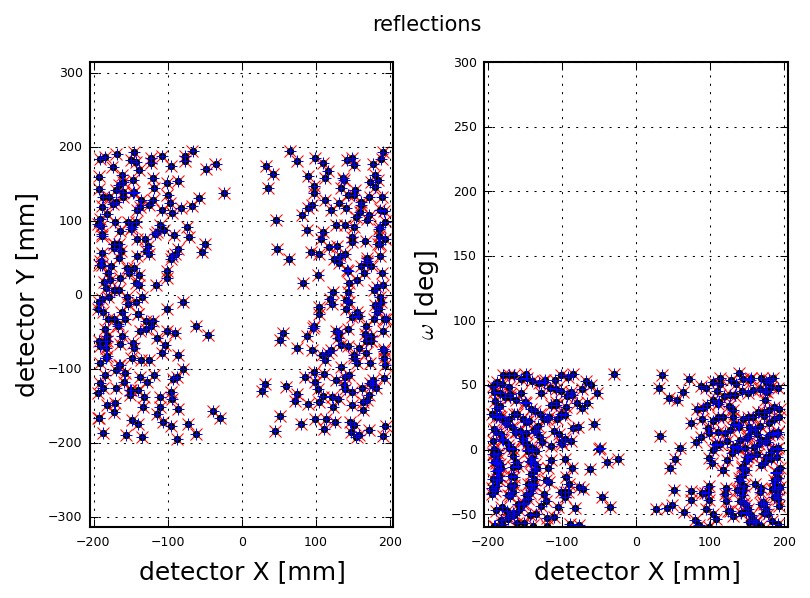

In [59]:
detectorParams = p_refined[:10]

# strain fitting
g_initial = np.hstack([results['expMap_c'].flatten(), results['tVec_c'].flatten(), vInv_s.flatten()])
g_refined = fitting.fitGrain(
    xyo_det, hkls, bMat, wlen, detectorParams, results['expMap_c'],
    results['tVec_c'], vInv_s, beamVec=bVec_ref, etaVec=eta_ref,
    distortion=(dFunc, results['dParams']), gFlag=gFlag, gScl=gScl,
    omePeriod=omePeriod
    )

resd_f2 = fitting.objFuncFitGrain(
    g_refined[gFlag], g_refined, gFlag, detectorParams,
    xyo_det, hkls, bMat, wlen, bVec_ref, eta_ref, dFunc,
    results['dParams'], omePeriod, simOnly=False
    )
xyo_f2 = fitting.objFuncFitGrain(
    g_refined[gFlag], g_refined, gFlag, detectorParams,
    xyo_det, hkls, bMat, wlen, bVec_ref, eta_ref, dFunc,
    results['dParams'], omePeriod, simOnly=True
    )

nu_fac = 1/(nrefl - sum(gFlag) - 1.)
chi2_f2 = nu_fac*sum(resd_f2**2/xyo_f2.flatten())
print "Review of chi2 values:\n\tInitial\t\tDetector only\tStrain fit\n"
print "\t-------\t\t-------------\t----------"
print "\t%.4e\t%.4e\t%.4e" %(chi2_i, chi2_f, chi2_f2)
print "\nCalibrant Hencky Strain Tensor (sample frame):\n"
print logm(np.linalg.inv(mutil.vecMVToSymm(g_refined[6:])))
print "\nCentroidal coordinates [microns]:"
print "\tX\t\tY\t\tZ"
print "\t%.3e\t%.3e\t%.3e" %tuple(1e3*g_refined[3:6])

fid = open(new_parfilename, 'w')
# initialize output dictionsary
# DARREN: better way?
new_par = {
           'oscillation_stage':{
                                'chi':0., 
                                't_vec_s':np.zeros(3)
                                }, 
           'detector':{'id':'GE', 
                       'pixels':{'rows':2048, 'columns':2048, 'size':[0.2, 0.2]}, 
                       'transform':{'tilt_angles':np.zeros(3), 't_vec_d':np.zeros(3)}, 
                       'distortion':{'function_name':'GE_41RT', 'parameters':np.zeros(6)},
                       'saturation_level':int_cutoff
                       }, 
           'calibration_crystal':{'grain_id':0, 
                                  'orientation':np.zeros(3), 
                                  'position':np.zeros(3), 
                                  'inv_stretch':np.hstack([np.ones(3), np.zeros(3)])
                                  }
           }

new_par['oscillation_stage']['chi'] = float(results['chi'])
new_par['oscillation_stage']['t_vec_s'] = results['tVec_s'].flatten().tolist()

# ...chicken and egg problem here, until this format is standard
new_par['detector']['pixels']['rows'] = 2048
new_par['detector']['pixels']['columns'] = 2048
new_par['detector']['pixels']['size'] = [0.2, 0.2]

new_par['detector']['transform']['tilt_angles'] = np.array(results['tiltAngles']).tolist()
new_par['detector']['transform']['t_vec_d'] = results['tVec_d'].flatten().tolist()

new_par['detector']['distortion']['function_name'] = 'GE_41RT' # only choice besides None for now
new_par['detector']['distortion']['parameters'] = results['dParams'].tolist()

new_par['calibration_crystal']['grain_id'] = grain_id
new_par['calibration_crystal']['orientation'] = g_refined[:3].tolist()
new_par['calibration_crystal']['position'] = g_refined[3:6].tolist()
new_par['calibration_crystal']['inv_stretch'] = g_refined[6:].tolist()

print >> fid, yaml.dump(new_par); fid.close()

fid = open(new_parfilename.split('.')[0] + '.par', 'w')

print >> fid, \
    "%1.7e\t# tiltAngles[0]\n" % (results['tiltAngles'][0]) + \
    "%1.7e\t# tiltAngles[1]\n" % (results['tiltAngles'][1]) + \
    "%1.7e\t# tiltAngles[2]\n" % (results['tiltAngles'][2]) + \
    "%1.7e\t# tVec_d[0]    \n" % (results['tVec_d'][0])     + \
    "%1.7e\t# tVec_d[1]    \n" % (results['tVec_d'][1])     + \
    "%1.7e\t# tVec_d[2]    \n" % (results['tVec_d'][2])     + \
    "%1.7e\t# chi          \n" % (results['chi'])           + \
    "%1.7e\t# tVec_s[0]    \n" % (results['tVec_s'][0])     + \
    "%1.7e\t# tVec_s[1]    \n" % (results['tVec_s'][1])     + \
    "%1.7e\t# tVec_s[2]    \n" % (results['tVec_s'][2])     + \
    "%1.7e\t# expMap_c[0]  \n" % (g_refined[0])             + \
    "%1.7e\t# expMap_c[1]  \n" % (g_refined[1])             + \
    "%1.7e\t# expMap_c[2]  \n" % (g_refined[2])             + \
    "%1.7e\t# tVec_c[0]    \n" % (g_refined[3])             + \
    "%1.7e\t# tVec_c[1]    \n" % (g_refined[4])             + \
    "%1.7e\t# tVec_c[2]    \n" % (g_refined[5])             + \
    "%1.7e\t# vInv_s[0]    \n" % (g_refined[6])             + \
    "%1.7e\t# vInv_s[1]    \n" % (g_refined[7])             + \
    "%1.7e\t# vInv_s[2]    \n" % (g_refined[8])             + \
    "%1.7e\t# vInv_s[3]    \n" % (g_refined[9])             + \
    "%1.7e\t# vInv_s[4]    \n" % (g_refined[10])            + \
    "%1.7e\t# vInv_s[5]    \n" % (g_refined[11])
fid.close()

# new style method 2; use an axes array
fig3, axs3 = plt.subplots(1, 3, sharex=False, sharey=True)
fig3.subplots_adjust(wspace=0)
fig3.suptitle("Residuals", fontsize=14, y=1.0)
titles = [r'$\Delta$X [mm]', r'$\Delta$Y [mm]', r'$\Delta\omega$']
for i in range(3):
    axs3[i].hist(resd_f.reshape(sum(idx_new), 3)[:, i], color='b')
    axs3[i].hist(resd_f2.reshape(sum(idx_new), 3)[:, i], color='g', alpha=0.5)
    axs3[i].set_title(titles[i], fontsize=12)
    if i > 1:
        axs3[i].set_xlim(-0.0007, np.max(resd_f.reshape(sum(idx_new), 3)[:, i])+0.0007)
        axs3[i].set_xlim(-0.0007, np.max(resd_f.reshape(sum(idx_new), 3)[:, i])+0.0007)
    else:
        axs3[i].set_xlim(-0.57, 0.57)

fig4, axs4 = plt.subplots(1, 2, sharex=True, sharey=False)
fig4.subplots_adjust(wspace=0.3)
fig4.suptitle("reflections")

axs4[0].plot(xyo_det[:, 0], xyo_det[:, 1], 'rx')
axs4[0].plot(xyo_f[:, 0], xyo_f[:, 1], 'k.')
axs4[0].plot(xyo_f2[:, 0], xyo_f2[:, 1], 'b+')
axs4[0].grid(True)
axs4[0].axis('equal')
axs4[0].set_xlim((-204.8, 204.8))
axs4[0].set_ylim((-204.8, 204.8))
axs4[0].set_xlabel('detector X [mm]')
axs4[0].set_ylabel('detector Y [mm]')

axs4[1].plot(xyo_det[:, 0], r2d*xyo_det[:, 2], 'rx')
axs4[1].plot(xyo_f[:, 0], r2d*xyo_f[:, 2], 'k.')
axs4[1].plot(xyo_f2[:, 0], r2d*xyo_f2[:, 2], 'b+')
axs4[1].grid(True)
axs4[1].set_xlim((-204.8, 204.8))
axs4[1].set_ylim(r2d*omePeriod[0], r2d*omePeriod[1])
axs4[1].set_xlabel('detector X [mm]')
axs4[1].set_ylabel(r'$\omega$ [deg]')